In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Schematic of synthesis and decay

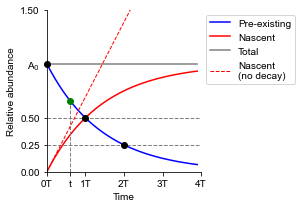

In [5]:
A0 = 1
T = 1
xs = np.arange(0, 4, 0.1)
ys = np.array([A0 * 2** (- x / T) for x in xs])

plt.figure(figsize=(4.3, 3))
plt.plot(xs, ys, color="blue", label="Pre-existing")
plt.plot(xs, 1 - ys, color="red", label="Nascent")
plt.plot(xs, [1] * len(ys), color="grey", label="Total")
plt.scatter([0, 1, 2], [1, 0.5, 0.25], color="black", clip_on=False, zorder=20)
plt.axhline(0.25, lw=1, ls="--", color="grey")
plt.axhline(0.5, lw=1, ls="--", color="grey")

plt.scatter([0.6], ys[6], marker="o", color="green", zorder=20)
plt.plot([0.6, 0.6], [0, ys[6]], ls="--", lw=1, color="grey")

ys1 = [x * A0 * np.log(2) / T for x in xs]
plt.plot(xs, ys1, lw=1, ls="--", color="red", label="Nascent\n(no decay)")

plt.xticks([0, 0.6, 1, 2, 3, 4], ["0T", "t", "1T", "2T", "3T", "4T"])
plt.yticks([0, 0.25, 0.5, 1, 1.5], ["0.00", "0.25", "0.50", "A$_0$", "1.50"])
plt.xlabel("Time")
plt.ylabel("Relative abundance")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlim(0, 4)
plt.ylim(0, 1.5)
plt.legend(ncol=1, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("figures/halflife_schematic.pdf", dpi=300)

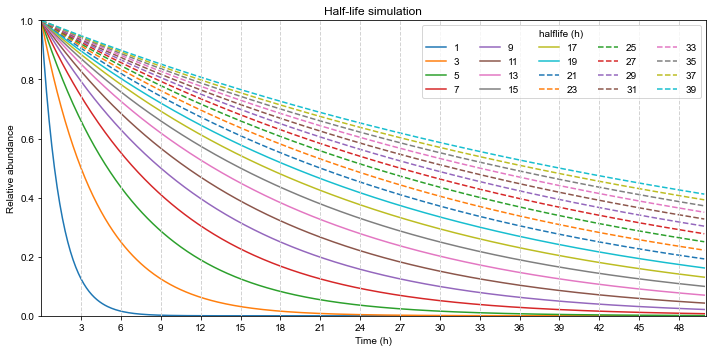

In [4]:
plt.figure(figsize=(10, 5))
plt.title("Half-life simulation")
for T in range(1, 40, 2):
    xs = np.arange(0, 50, 0.1)
    ys = [0.5 ** (x / T) for x in xs]
    plt.plot(xs, ys, label=str(T), ls=["-", "--"][int(T/20)])
xs = list(range(3, 50, 3))
for x in xs:
    plt.axvline(x, color="lightgrey", ls="--", lw=1)
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.legend(ncol=5, title="halflife (h)")
plt.xticks(xs)
plt.xlabel("Time (h)")
plt.ylabel("Relative abundance")
plt.tight_layout()
plt.savefig("figures/halflife_simulation.pdf", dpi=300)

# High synthesis genes

In [35]:
for strain in ["K562", "mESC"]:
    print("-" * 80)
    print(strain)
    s4u = 50
    if strain == "mESC":
        s4u = 400
    dat = pd.read_excel("../1_NanoNASCseq/NanoNASCseq_filtered.100k_reads_and_2k_genes.xls")
    d = dat[(dat["Strain"] == strain) & (dat["s4U"] == s4u) & (dat["Time"] == 3) & (np.isnan(dat["ActD"]))]
    print("Total cells:", len(d))
    min_tc = 0.008
    if strain == "mESC":
        min_tc = 0.015
    d = d[d["TC"] >= min_tc]
    print("Filtered cells:", len(d))
    
    counter = dict()
    for run, cell in d[["Run", "Cell"]].values:
        path = "../1_NanoNASCseq/results/nascent/quantify/%s/%s.tsv" % (run, cell)
        df = pd.read_csv(path, sep="\t", index_col=0)
        for gid, (total, nascent) in zip(df.index, df[["Total", "Nascent"]].values):
            if gid not in counter:
                counter[gid] = np.zeros(2)
            counter[gid] += np.array([total, nascent])
            
    df = pd.DataFrame(list(counter.values()),
                      index=pd.Index(list(counter.keys()), name="GeneID"), 
                      columns=["Total", "Nascent"])
    df["NTR"] = df["Nascent"] / df["Total"]
    df["A0"] = df["Total"]
    df["T"] = -3 / np.log2(1 - df["NTR"])
    df["K"] = df["A0"] / df["T"] * np.log(2)
    path = "/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.genes.tsv"
    if strain == "mESC":
        path = "/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv"
    anno = pd.read_csv(path, sep="\t", index_col=2)
    df = df.merge(anno, left_index=True, right_index=True)
    df = df[~df["GeneName"].duplicated()]
    df1 = df[df["A0"] >= 100]
    df1 = df1.sort_values(by="K")
    df1.tail(500)["GeneName"].to_csv(outdir + "/high_synthesis_genes.%s.txt" % strain, index=False)

--------------------------------------------------------------------------------
K562
Total cells: 139
Filtered cells: 100


/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log2


--------------------------------------------------------------------------------
mESC
Total cells: 102
Filtered cells: 92


In [ ]:
! clusterProfiler_wrapper.sh figures4/high_synthesis_genes.K562.txt Human figures4/high_synthesis_genes.K562
! clusterProfiler_wrapper.sh figures4/high_synthesis_genes.mESC.txt Mouse figures4/high_synthesis_genes.mESC